# Face detection using pre-trained model

We use following blog as a reference:
[Face detection with OpenCV and deep learning](https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/)

Import required Python libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt

Start webcam

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Click 'Capture' to make photo using your webcam.

In [ ]:
image_file = take_photo()

<IPython.core.display.Javascript object>

Read, resize and display the image.

400 300


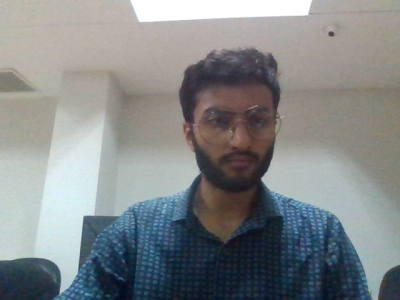

In [ ]:
#image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

OpenCV’s deep learning face detector is based on the Single Shot Detector (SSD) framework with a ResNet base network. The network is defined and trained using the [Caffe Deep Learning framework](https://caffe.berkeleyvision.org/)

Download the pre-trained face detection model, consisting of two files:

- The network definition (deploy.prototxt)
- The learned weights (res10_300x300_ssd_iter_140000.caffemodel)

In [ ]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2024-08-28 10:29:42--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.004s  

Last-modified header missing -- time-stamps turned off.
2024-08-28 10:29:42 (6.53 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2024-08-28 10:29:42--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Load the pre-trained face detection network model from disk

In [ ]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


Use the [dnn.blobFromImage](https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/) function to construct an input blob by resizing the image to a fixed 300x300 pixels and then normalizing it.


In [ ]:
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))


Pass the blob through the neural network and obtain the detections and predictions.

In [ ]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()
print(detections.shape)

[INFO] computing object detections...
(1, 1, 200, 7)


Loop over the detections and draw boxes around the detected faces

In [ ]:
for i in range(0, detections.shape[2]):

	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence threshold
	if confidence > 0.9:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		intbox =  box.astype("int")
		print(intbox)
		# ensure the detected bounding box does fall outside the dimensions of the frame
		# draw the bounding box of the face along with the associated probability
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)

		print(box)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

[191  78 275 185]
[191.62399769  78.62089276 275.83243847 185.63674092]


Show the resulting image

In [ ]:
cv2_imshow(image)


In [ ]:
# Original image, which is the background
background = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Image of the object
img = cv2.imread('/content/drive/MyDrive/hat5.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Image the object's mask
mask = cv2.imread('/content/drive/MyDrive/hat_mask5.jpeg')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)


print("Background shape:", background.shape)
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

Background shape: (300, 400, 3)
Image shape: (100, 100, 3)
Mask shape: (100, 100, 3)


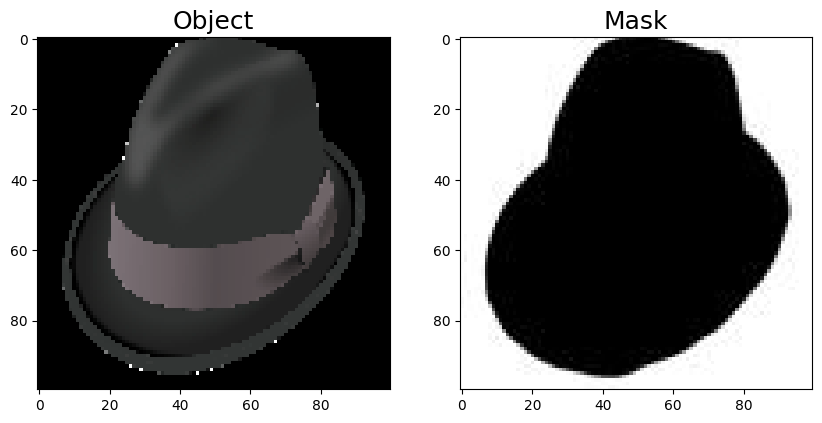

In [ ]:
plt.figure(figsize=(10,12))
plt.title("Background", fontsize=18)
plt.imshow(background);

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(img)
ax[0].set_title('Object', fontsize=18)
ax[1].imshow(mask)
ax[1].set_title('Mask', fontsize=18);

In [ ]:
def remove_obj_background(img_path, mask_path):
    '''
    Function returns:
    - image of the object with removed background in CV2 RGB format (numpy array with dimensions (width, height, 3))
    - boolean mask of the object (numpy array with dimensions (width, height))
    '''
    img = cv2.imread('/content/drive/MyDrive/hat4.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread('/content/drive/MyDrive/hat_mask4.jpeg')
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    h, w = mask.shape[0], mask.shape[1]

    # Boolean mask is a numpy array with two dimensions: width and height.
    # On the original mask, object area is filled with black color, background area is filled with white color.
    # On the boolean mask, object area is filled with True, background area is filled with False.
    mask_boolean = mask[:,:,0] == 0
    img_with_removed_background = img * np.stack([mask_boolean, mask_boolean, mask_boolean], axis=2)

    return img_with_removed_background, mask_boolean

img_with_removed_background, mask_boolean = remove_obj_background('cup.png', 'cup_mask.png')
print("Shape of the image of the object:", img_with_removed_background.shape)
print("Shape of the boolean mask:", mask_boolean.shape)
print("\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_with_removed_background)
ax[0].set_title('Object with removed background', fontsize=18)
ax[1].imshow(mask_boolean)
ax[1].set_title('Boolean mask', fontsize=18);

Shape of the image of the object: (50, 50, 3)
Shape of the boolean mask: (50, 50)




In [ ]:
def add_obj(background, img, mask, x, y):
    '''
    Arguments:
    background - background image in CV2 RGB format
    img - image of object in CV2 RGB format
    mask - mask of object in CV2 RGB format
    x, y - coordinates of the center of the object image
    0 < x < width of background
    0 < y < height of background

    Function returns background with added object in CV2 RGB format

    CV2 RGB format is a numpy array with dimensions width x height x 3
    '''

    bg = background.copy()

    h_bg, w_bg = bg.shape[0], bg.shape[1]

    h, w = img.shape[0], img.shape[1]

    # Calculating coordinates of the top left corner of the object image
    x = x - int(w/2)
    y = y - int(h/2)

    mask_boolean = mask[:,:,0] == 0
    mask_rgb_boolean = np.stack([mask_boolean, mask_boolean, mask_boolean], axis=2)

    if x >= 0 and y >= 0:

        h_part = h - max(0, y+h-h_bg) # h_part - part of the image which overlaps background along y-axis
        w_part = w - max(0, x+w-w_bg) # w_part - part of the image which overlaps background along x-axis

        bg[y:y+h_part, x:x+w_part, :] = bg[y:y+h_part, x:x+w_part, :] * ~mask_rgb_boolean[0:h_part, 0:w_part, :] + (img * mask_rgb_boolean)[0:h_part, 0:w_part, :]

    elif x < 0 and y < 0:

        h_part = h + y
        w_part = w + x

        bg[0:0+h_part, 0:0+w_part, :] = bg[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_boolean[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_boolean)[h-h_part:h, w-w_part:w, :]

    elif x < 0 and y >= 0:

        h_part = h - max(0, y+h-h_bg)
        w_part = w + x

        bg[y:y+h_part, 0:0+w_part, :] = bg[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_boolean[0:h_part, w-w_part:w, :] + (img * mask_rgb_boolean)[0:h_part, w-w_part:w, :]

    elif x >= 0 and y < 0:

        h_part = h + y
        w_part = w - max(0, x+w-w_bg)

        bg[0:0+h_part, x:x+w_part, :] = bg[0:0+h_part, x:x+w_part, :] * ~mask_rgb_boolean[h-h_part:h, 0:w_part, :] + (img * mask_rgb_boolean)[h-h_part:h, 0:w_part, :]

    return bg

In [ ]:
composition_1 = add_obj(background, img, mask, 200,20)
plt.figure(figsize=(15,15))
plt.imshow(composition_1);